In [20]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd
import plotly.plotly as py
from pandas import DataFrame,Series
import csv
import pprint
from sklearn.cluster import KMeans,FeatureAgglomeration
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA,FastICA
from sklearn.cross_decomposition import CCA
import statsmodels.api as sm
from sklearn.multioutput import MultiOutputRegressor
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Others
import math
import datetime


# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 16, 8

In [2]:
train_volume = pd.read_csv(
    '../datasets/train/volume(table_6)_training.csv',
    parse_dates=True,
    index_col=[0]
)
train_volume2 = pd.read_csv(
    '../datasets/train/volume(table_6)_training2.csv',
    parse_dates=True,
    index_col=[0]
)

volume = pd.concat([
    train_volume,
    train_volume2
])
volume['counter'] = 1
volume['route'] = 'T' + \
    volume.tollgate_id.map(str) + 'D' + volume.direction.map(str)
del volume['tollgate_id']
del volume['direction']

del train_volume
del train_volume2

train_weather = pd.read_csv(
    '../datasets/train/weather_(table_7)_training_update.csv')
train_weather2 = pd.read_csv(
    '../datasets/train/weather_(table_7)_2.csv')

weather = pd.concat([
    train_weather,
    train_weather2
])
del train_weather
del train_weather2

In [3]:
volume_grouped = volume.groupby(['route']).resample('20min').count()[
    'counter'].unstack().T.fillna(0).astype(int)
holidays_index = pd.date_range('2016-9-30', '2016-10-9', freq='20min')
volume_grouped = volume_grouped.loc[volume_grouped.index.difference(
    holidays_index)]

In [4]:
index = volume_grouped.between_time('0:00','00:40').index
volume_grouped.loc[index,['T1D1','T3D1']] = 0
volume_grouped.index = pd.MultiIndex.from_arrays(
    [volume_grouped.index.date, volume_grouped.index.time], names=['date', 'time'])
volume_grouped = volume_grouped.unstack()

In [5]:
validate_index = pd.date_range('2016-10-20', '2016-10-24').date
training_index = volume_grouped.index.difference(validate_index)

In [6]:
pca = PCA(n_components=1)
pca_volume_grouped = pca.fit_transform(volume_grouped.loc[training_index].stack())

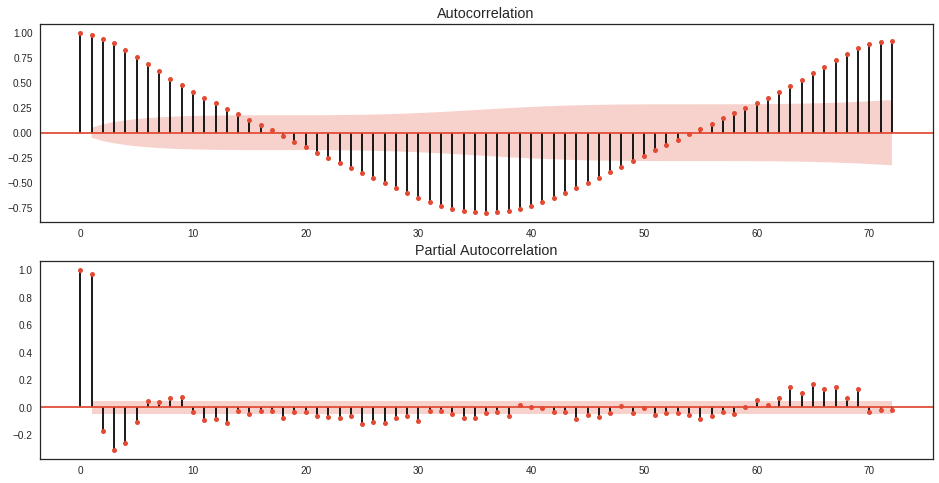

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pca_volume_grouped.flatten(), lags=72, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pca_volume_grouped.flatten(), lags=72, ax=ax2)

In [704]:
pca.explained_variance_ratio_

array([ 0.91934428])

In [33]:
S = 72
d, D = 0, 0
p, q = 3, 1
P, Q = 2, 0
order=(p, d, q)
seasonal_order=(P, D, Q, S)

In [34]:
mod = sm.tsa.statespace.SARIMAX(
    endog=pca_volume_grouped.flatten(),
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [35]:
results = mod.fit()

/usr/local/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [36]:
results.summary()

/usr/local/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:1036: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/statespace/mlemodel.py:1964: RuntimeWarning:

divide by zero encountered in true_divide



<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1583
Model:             SARIMAX(13, 0, 1)x(1, 0, 0, 72)   Log Likelihood               -6090.993
Date:                             Thu, 25 May 2017   AIC                          12213.986
Time:                                     22:40:51   BIC                          12299.859
Sample:                                          0   HQIC                         12245.891
                                            - 1583                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4822     66.239      0.022      0.982    -128.343     131.307
ar.L2         -0.2654     90.494     -0.003      0.998    -177.631     177.100
ar.L3         -0.1342     95.804     -0.001      0.999    -187.907     187.639
ar.L4         -0.0073    103.187  -7.06e-05      1.000    -202.251     202.236
ar.L5         -0.1559    102.088     -0.002      0.999    -200.245     199.933
ar.L6          0.1236    104.357      0.001      0.999    -204.412     204.659
ar.L7         -0.1824     98.802     -0.002      0.999    -193.830     193.465
ar.L8          0.0526    103.200      0.001      1.000    -202.215     202.320
ar.L9          0.0891    104.117      0.001      0.999    -203.976     204.155
ar.L10         0.0538    107.853      0.000      1.000    -211.335     211.443
ar.L11        -0.0103    108.939  -9.43e-05      1.000    -213.527     213.506
ar.L12        -0.0716    109.700     -0.001      0.999    -215.081     214.937
ar.L13        -0.0025     94.164  -2.65e-05      1.000    -184.561     184.556
ma.L1         -0.8672          0       -inf      0.000      -0.867      -0.867
ar.S.L72       0.6631     62.886      0.011      0.992    -122.592     123.918
sigma2       206.1320   1.14e-09    1.8e+11      0.000     206.132     206.132
===================================================================================
Ljung-Box (Q):                       66.18   Jarque-Bera (JB):               364.32
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.41
Prob(H) (two-sided):                  0.77   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.25e+54. Standard errors may be unstable.
"""